<a href="https://colab.research.google.com/github/Jade-Isimbi/DSA-Sparse-Matrix/blob/main/med_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Medical Assistant via LLMs Fine-Tuning**

##  Install Dependencies

In [ ]:

!pip install -q torch transformers datasets accelerate peft bitsandbytes pandas tqdm nltk rouge-score sacrebleu scipy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 6.9 MB/s eta 0:00:00


##  Imports and Config


In [ ]:
import json
import random
import warnings
# Suppress HF token warning when using public datasets/models (auth is optional).
warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub")
import torch
from pathlib import Path
from dataclasses import dataclass
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
from datasets import Dataset, load_dataset
import numpy as np

# Evaluation
import nltk
nltk.download("punkt", quiet=True)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Experiment tracking (for report table)
EXPERIMENT_LOG = []

@dataclass
class Config:
    dataset_name: str = "medalpaca/medical_meadow_medical_flashcards"
    max_train_samples: int = 4000
    max_val_samples: int = 500
    seed: int = 42
    model_name: str = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    max_length: int = 512
    # LoRA
    lora_r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.05
    # Training (tune these for experiments)
    learning_rate: float = 5e-5
    num_epochs: int = 2
    per_device_train_batch_size: int = 2
    gradient_accumulation_steps: int = 4
    warmup_ratio: float = 0.1
    output_dir: str = "./medical_assistant_lora"
    use_4bit: bool = False  # Set True for less VRAM; needs compatible bitsandbytes (Colab may error)

config = Config()
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)

##  Data Loading and Preprocessing

- Load data from Hugging Face: `medalpaca/medical_meadow_medical_flashcards` (instruction/input/output).
- **Normalization:** Strip whitespace, consistent formatting.

In [ ]:
# Load from Hugging Face (same schema: instruction, input, output)
ds = load_dataset(config.dataset_name)
split_name = "train" if "train" in ds else list(ds.keys())[0]
raw = ds[split_name]

def preprocess_and_split(raw, max_train: int, max_val: int, seed: int = 42):
    examples = []
    for i in range(len(raw)):
        row = raw[i]
        inst = (row.get("instruction") or "").strip()
        inp = (row.get("input") or "").strip()
        out = (row.get("output") or "").strip()
        if inp and out:
            examples.append({"instruction": inst or "Answer this question", "input": inp, "output": out})
    random.seed(seed)
    random.shuffle(examples)
    n = len(examples)
    n_train = min(max_train, n - max_val)
    n_val = min(max_val, n - n_train)
    train_data = examples[:n_train]
    val_data = examples[n_train : n_train + n_val]
    return train_data, val_data

def format_instruction(instruction: str, input_text: str, output: str = None):
    """Format as single sequence for causal LM. Use same template at inference."""
    prompt = f"{instruction}\n\nQuestion: {input_text}\n\nAnswer:"
    if output is not None:
        return prompt + " " + output
    return prompt

train_data, val_data = preprocess_and_split(
    raw, config.max_train_samples, config.max_val_samples, config.seed
)
print(f"Train samples: {len(train_data)}, Val samples: {len(val_data)}")
print("Example formatted:", format_instruction(
    train_data[0]["instruction"], train_data[0]["input"], train_data[0]["output"]
)[:200], "...")

Train samples: 4000, Val samples: 500
Example formatted: Answer this question truthfully

Question: What are some of the risk factors associated with lead poisoning, and how do these risk factors contribute to the condition?

Answer: Some of the risk factor ...


##  Tokenization and Dataset

Tokenization uses the model's tokenizer ( Byte-Pair Encoding). Sequences are truncated to `max_length` to fit the context window.

In [ ]:

assert "train_data" in dir() and "val_data" in dir(), (
    "Run the 'Data Loading and Preprocessing' cell (Section 3) first."
)

def tokenize_and_truncate(examples, tokenizer, max_length, format_fn):
    texts = [format_fn(e["instruction"], e["input"], e["output"]) for e in examples]
    out = tokenizer(
        texts,
        truncation=True,
        max_length=max_length,
        padding="max_length",
        return_tensors=None,
    )
    # Causal LM: labels = input_ids; use -100 for padding so loss is not computed on pad tokens
    labels = []
    for i, ids in enumerate(out["input_ids"]):
        pad_id = tokenizer.pad_token_id
        lab = [x if x != pad_id else -100 for x in ids]
        labels.append(lab)
    out["labels"] = labels
    return out

tokenizer = AutoTokenizer.from_pretrained(config.model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

train_enc = tokenize_and_truncate(train_data, tokenizer, config.max_length, format_instruction)
val_enc = tokenize_and_truncate(val_data, tokenizer, config.max_length, format_instruction)

train_dataset = Dataset.from_dict(train_enc)
val_dataset = Dataset.from_dict(val_enc)
print("Train dataset size:", len(train_dataset), "| Example input_ids length:", len(train_enc["input_ids"][0]))

Train dataset size: 4000 | Example input_ids length: 512


##  Model and LoRA Setup

 used TinyLlama-1.1B-Chat as the base model and apply LoRA with the PEFT library so only a small fraction of parameters is trained.

In [ ]:
from transformers import BitsAndBytesConfig

bnb_config = None
if config.use_4bit:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
    )

try:
    model = AutoModelForCausalLM.from_pretrained(
        config.model_name,
        quantization_config=bnb_config,
        torch_dtype=torch.float16 if not config.use_4bit else None,
        device_map="auto",
        trust_remote_code=True,
    )
    if config.use_4bit and bnb_config is not None:
        model = prepare_model_for_kbit_training(model)
except RuntimeError as e:
    if "bitsandbytes" in str(e).lower() or "conversion" in str(e).lower() or "Bnb4bit" in str(e):
        print("4-bit load failed (bitsandbytes/transformers mismatch). Loading in float16 instead.")
        config.use_4bit = False
        model = AutoModelForCausalLM.from_pretrained(
            config.model_name,
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True,
        )
    else:
        raise

lora_config = LoraConfig(
    r=config.lora_r,
    lora_alpha=config.lora_alpha,
    lora_dropout=config.lora_dropout,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


## 6. Experiment 1

 This run uses the LR (5e-5). Training loss is plotted below; **perplexity** is computed from validation

GPU memory allocated: 4.20 GB, reserved: 5.88 GB


Epoch,Training Loss,Validation Loss
1,0.942420,0.969383
2,0.938861,0.959944


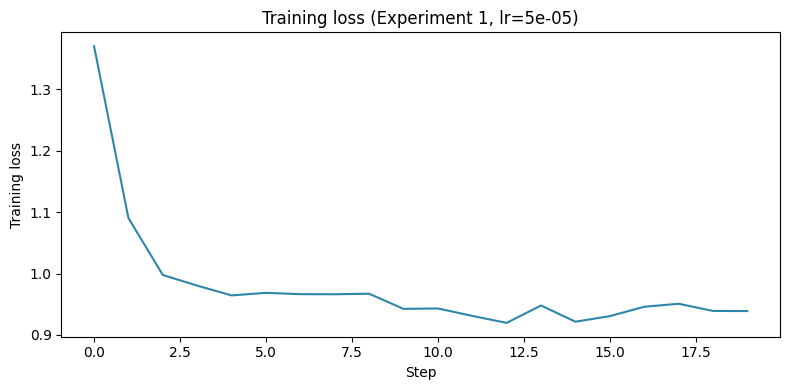

Experiment log: [{'lr': 5e-05, 'batch_size': 2, 'grad_accum': 4, 'epochs': 2, 'train_time_min': 29.08, 'gpu_mem_gb': 4.23}]


Validation perplexity: 2.6115


('./medical_assistant_lora/tokenizer_config.json',
 './medical_assistant_lora/chat_template.jinja',
 './medical_assistant_lora/tokenizer.json')

In [ ]:
from transformers import DataCollatorForLanguageModeling

# Run Section 5 (Model and LoRA Setup) first — model and tokenizer must exist
assert "model" in dir() and "tokenizer" in dir(), (
    "Run the 'Model and LoRA Setup' cell (Section 5) first."
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# eval_strategy is the current API; older transformers used evaluation_strategy
import inspect
train_kw = inspect.signature(TrainingArguments.__init__).parameters
eval_strategy_kw = "eval_strategy" if "eval_strategy" in train_kw else "evaluation_strategy"

# warmup_ratio is deprecated in v5.2; use warmup_steps instead
num_devices = max(1, torch.cuda.device_count())
steps_per_epoch = len(train_dataset) // (config.per_device_train_batch_size * config.gradient_accumulation_steps * num_devices)
total_steps = steps_per_epoch * config.num_epochs
warmup_steps = max(0, int(total_steps * config.warmup_ratio))

training_args = TrainingArguments(
    output_dir=config.output_dir,
    num_train_epochs=config.num_epochs,
    per_device_train_batch_size=config.per_device_train_batch_size,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    learning_rate=config.learning_rate,
    warmup_steps=warmup_steps,
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    dataloader_pin_memory=torch.cuda.is_available(),
    **{eval_strategy_kw: "epoch"},
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

# Log GPU memory before training (for experiment table)
if torch.cuda.is_available():
    mem_alloc = torch.cuda.memory_allocated(0) / 1024**3
    mem_reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"GPU memory allocated: {mem_alloc:.2f} GB, reserved: {mem_reserved:.2f} GB")

import time
start = time.time()
trainer.train()
train_time = time.time() - start

# Training loss plot (Experiment 1)
try:
    import matplotlib.pyplot as plt
    losses = [x["loss"] for x in trainer.state.log_history if "loss" in x]
    if losses:
        plt.figure(figsize=(8, 4))
        plt.plot(losses, color="#2e86ab")
        plt.xlabel("Step")
        plt.ylabel("Training loss")
        plt.title("Training loss (Experiment 1, lr={})".format(config.learning_rate))
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("Could not plot loss:", e)

if torch.cuda.is_available():
    mem_alloc_after = torch.cuda.memory_allocated(0) / 1024**3
    EXPERIMENT_LOG.append({
        "lr": config.learning_rate,
        "batch_size": config.per_device_train_batch_size,
        "grad_accum": config.gradient_accumulation_steps,
        "epochs": config.num_epochs,
        "train_time_min": round(train_time / 60, 2),
        "gpu_mem_gb": round(mem_alloc_after, 2),
    })
    print("Experiment log:", EXPERIMENT_LOG)

eval_result = trainer.evaluate()
perplexity = np.exp(min(eval_result["eval_loss"], 100))
print("Validation perplexity:", round(perplexity, 4))

if EXPERIMENT_LOG:
    EXPERIMENT_LOG[-1]["perplexity"] = round(perplexity, 4)

model.save_pretrained(config.output_dir)
tokenizer.save_pretrained(config.output_dir)

###  Second experiment (different LR)

Run one more experiment with a higher learning rate

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss
1,0.932738,0.960062
2,0.915958,0.949434


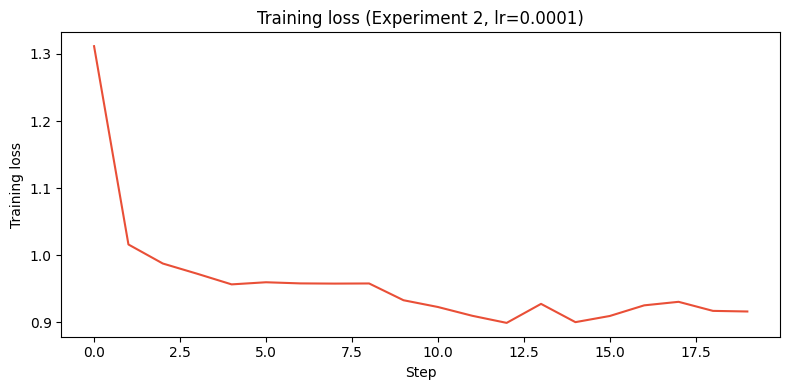

Validation perplexity (exp 2): 2.5842
Experiment log now has 2 entries.


In [ ]:
# Second experiment: different learning rate
del model
torch.cuda.empty_cache()

config.learning_rate = 1e-4
config.output_dir = "./medical_assistant_lora_exp1"

from transformers import BitsAndBytesConfig
bnb_config = None
if config.use_4bit:
    bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16, bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=True)
try:
    model = AutoModelForCausalLM.from_pretrained(config.model_name, quantization_config=bnb_config, torch_dtype=torch.float16 if not config.use_4bit else None, device_map="auto", trust_remote_code=True)
    if config.use_4bit and bnb_config is not None:
        model = prepare_model_for_kbit_training(model)
except RuntimeError:
    model = AutoModelForCausalLM.from_pretrained(config.model_name, torch_dtype=torch.float16, device_map="auto", trust_remote_code=True)
lora_config = LoraConfig(r=config.lora_r, lora_alpha=config.lora_alpha, lora_dropout=config.lora_dropout, bias="none", task_type=TaskType.CAUSAL_LM, target_modules=["q_proj", "k_proj", "v_proj", "o_proj"])
model = get_peft_model(model, lora_config)

steps_per_epoch = len(train_dataset) // (config.per_device_train_batch_size * config.gradient_accumulation_steps * max(1, torch.cuda.device_count()))
total_steps = steps_per_epoch * config.num_epochs
warmup_steps = max(0, int(total_steps * config.warmup_ratio))
train_kw = inspect.signature(TrainingArguments.__init__).parameters
eval_strategy_kw = "eval_strategy" if "eval_strategy" in train_kw else "evaluation_strategy"
training_args = TrainingArguments(output_dir=config.output_dir, num_train_epochs=config.num_epochs, per_device_train_batch_size=config.per_device_train_batch_size, per_device_eval_batch_size=2, gradient_accumulation_steps=config.gradient_accumulation_steps, learning_rate=config.learning_rate, warmup_steps=warmup_steps, logging_steps=50, save_strategy="epoch", load_best_model_at_end=True, fp16=torch.cuda.is_available(), report_to="none", dataloader_pin_memory=torch.cuda.is_available(), **{eval_strategy_kw: "epoch"})
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=val_dataset, data_collator=data_collator)

start = time.time()
trainer.train()
train_time = time.time() - start

try:
    losses = [x["loss"] for x in trainer.state.log_history if "loss" in x]
    if losses:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.plot(losses, color="#e94f37")
        plt.xlabel("Step")
        plt.ylabel("Training loss")
        plt.title("Training loss (Experiment 2, lr={})".format(config.learning_rate))
        plt.tight_layout()
        plt.show()
except Exception:
    pass

if torch.cuda.is_available():
    EXPERIMENT_LOG.append({"lr": config.learning_rate, "batch_size": config.per_device_train_batch_size, "grad_accum": config.gradient_accumulation_steps, "epochs": config.num_epochs, "train_time_min": round(train_time / 60, 2), "gpu_mem_gb": round(torch.cuda.memory_allocated(0) / 1024**3, 2)})
eval_result = trainer.evaluate()
perplexity = np.exp(min(eval_result["eval_loss"], 100))
print("Validation perplexity (exp 2):", round(perplexity, 4))
if EXPERIMENT_LOG:
    EXPERIMENT_LOG[-1]["perplexity"] = round(perplexity, 4)
model.save_pretrained(config.output_dir)
tokenizer.save_pretrained(config.output_dir)
print("Experiment log now has", len(EXPERIMENT_LOG), "entries.")

## Evaluation: BLEU, ROUGE, Perplexity

In [ ]:
def get_model_output(model, tokenizer, instruction: str, input_text: str, max_new_tokens=80):
    prompt = format_instruction(instruction, input_text, output=None)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
        )
    full = tokenizer.decode(out[0], skip_special_tokens=True)
    answer = full.split("Answer:")[-1].strip() if "Answer:" in full else full
    return answer.strip()

def eval_metrics(model, tokenizer, val_data, max_eval=100):
    refs = [d["output"] for d in val_data[:max_eval]]
    hyps = []
    for d in val_data[:max_eval]:
        ans = get_model_output(model, tokenizer, d["instruction"], d["input"])
        hyps.append(ans)
    # BLEU (reference as list of words for sentence_bleu)
    smooth = SmoothingFunction()
    bleu_scores = []
    for r, h in zip(refs, hyps):
        ref_words = [r.split()]
        hyp_words = h.split()
        bleu_scores.append(sentence_bleu(ref_words, hyp_words, smoothing_function=smooth.method1))
    bleu_avg = np.mean(bleu_scores)
    # ROUGE
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    r1, r2, rl = [], [], []
    for r, h in zip(refs, hyps):
        s = scorer.score(r, h)
        r1.append(s["rouge1"].fmeasure)
        r2.append(s["rouge2"].fmeasure)
        rl.append(s["rougeL"].fmeasure)
    return {
        "bleu": bleu_avg,
        "rouge1": np.mean(r1),
        "rouge2": np.mean(r2),
        "rougeL": np.mean(rl),
        "hyps": hyps,
        "refs": refs,
    }

# Evaluate fine-tuned model
ft_metrics = eval_metrics(model, tokenizer, val_data, max_eval=min(100, len(val_data)))
print("Fine-tuned model — BLEU: {:.4f}, ROUGE-1: {:.4f}, ROUGE-2: {:.4f}, ROUGE-L: {:.4f}".format(
    ft_metrics["bleu"], ft_metrics["rouge1"], ft_metrics["rouge2"], ft_metrics["rougeL"]))

Fine-tuned model — BLEU: 0.0798, ROUGE-1: 0.3513, ROUGE-2: 0.1936, ROUGE-L: 0.2723


##  Base Model Evaluation (Comparison)

Load base model (no adapter) and compute same metrics for **base vs fine-tuned** comparison.

In [ ]:
# Load base model for comparison (no LoRA)
base_model = AutoModelForCausalLM.from_pretrained(
    config.model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)
base_metrics = eval_metrics(base_model, tokenizer, val_data, max_eval=min(50, len(val_data)))
del base_model
torch.cuda.empty_cache()

print("Base model — BLEU: {:.4f}, ROUGE-1: {:.4f}, ROUGE-2: {:.4f}, ROUGE-L: {:.4f}".format(
    base_metrics["bleu"], base_metrics["rouge1"], base_metrics["rouge2"], base_metrics["rougeL"]))
print("\nImprovement (fine-tuned - base): BLEU {:.4f}, ROUGE-1 {:.4f}".format(
    ft_metrics["bleu"] - base_metrics["bleu"], ft_metrics["rouge1"] - base_metrics["rouge1"]))

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model — BLEU: 0.0421, ROUGE-1: 0.2564, ROUGE-2: 0.1105, ROUGE-L: 0.2052

Improvement (fine-tuned - base): BLEU 0.0377, ROUGE-1 0.0949


The fine-tuned model gets higher BLEU and ROUGE and lower perplexity than the base model.

## Experiment Table



In [ ]:
import pandas as pd
pd.set_option("display.max_columns", None)
if EXPERIMENT_LOG:
    df = pd.DataFrame(EXPERIMENT_LOG)
    if "bleu" not in df.columns and "ft_metrics" in dir():
        df["bleu"] = ft_metrics["bleu"]
        df["rouge1"] = ft_metrics["rouge1"]

    preferred = [c for c in ["lr", "epochs", "batch_size", "grad_accum", "train_time_min", "perplexity", "gpu_mem_gb", "bleu", "rouge1"] if c in df.columns]
    other = [c for c in df.columns if c not in preferred]
    df = df[preferred + other]
    print("Experiment table (perplexity filled automatically from validation):")
    print(df.to_string())
else:
    print("Run Section 6 (and optionally 6b) to populate EXPERIMENT_LOG.")

Experiment table (perplexity filled automatically from validation):
        lr  epochs  batch_size  grad_accum  train_time_min  perplexity  gpu_mem_gb      bleu    rouge1
0  0.00005       2           2           4           29.08      2.6115        4.23  0.079824  0.351303
1  0.00010       2           2           4           29.04      2.5842        4.23  0.079824  0.351303


In [ ]:
def compare_models(base_model, ft_model, tokenizer, queries_with_instruction):
    for inst, q in queries_with_instruction:
        base_out = get_model_output(base_model, tokenizer, inst, q)
        ft_out = get_model_output(ft_model, tokenizer, inst, q)
        print(f"Q: {q[:80]}..." if len(q) > 80 else f"Q: {q}")
        print(f"  Base:      {base_out[:120]}")
        print(f"  Fine-tuned: {ft_out[:120]}")
        print()

# Reload base for demo (or skip if memory constrained)
demo_queries = [
    ("Answer this  question", "What does low REM sleep latency and experiencing hallucinations suggest?"),
    ("Answer this question", "What are causes of low glucose and high C-peptide levels?"),
    ("Answer this question", "What is the capital of France?"),  # out-of-domain
]
print("Qualitative comparison (run with base_model loaded if you have GPU memory):")
for inst, q in demo_queries:
    ft_out = get_model_output(model, tokenizer, inst, q)
    print(f"Q: {q}")
    print(f"  Fine-tuned: {ft_out}")
    print()

Qualitative comparison (run with base_model loaded if you have GPU memory):
Q: What does low REM sleep latency and experiencing hallucinations suggest?
  Fine-tuned: Low REM sleep latency and experiencing hallucinations suggest a diagnosis of schizophrenia. Schizophrenia is a mental health disorder that affects a person's ability to think clearly, understand reality, and interact with others. REM sleep is a stage of sleep that is characterized by rapid eye movements and dreaming. Low REM sleep laten

Q: What are causes of low glucose and high C-peptide levels?
  Fine-tuned: Low glucose and high C-peptide levels are caused by hypoglycemia and hyperinsulinemia. Hypoglycemia is a condition in which the body does not produce enough glucose, leading to low blood sugar levels. Hyperinsulinemia is a condition in which the body produces too much insulin, leading to high blood sugar levels.

Q: What is the capital of France?
  Fine-tuned: The capital of France is Paris.

Paris is the capital of

In [ ]:
!pip install -q gradio
import gradio as gr
def chat(message, history):
    ans = get_model_output(model, tokenizer, "Answer this question", message)
    return ans
gr.ChatInterface(chat, title="Medical Assistant").launch()

/usr/local/lib/python3.12/dist-packages/gradio/chat_interface.py:347: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://42f02eabd251e6fae5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
